**2. Define a target metric to measure user engagement.**   

How would you define an ​engaged vs. ​unengaged​ user?   
* Please provide the business justification and associated visualisations / rationale in choosing your definition of engagement

# Engaged vs unengaged user - overall intuition


An **engaged customer** is a person who choosed at least one company’s product and use it with regular frequency, that is purpose specific. Product usage is not sole definition of engagement, it's just the easiest to capture measure.   
An engaged customer is someone who interact with brand – follows its social media, is responsive to comunication and promotions. It’s someone who recommends company product to others and teaches others how to use it. Caring for customers engagement is very important for company because the more engaged the customer are, the easier to improve company product and grow (sell more).     

On the other hand, **unengaged customer** does not use product with constant frequency, is not happy about product or is neutral towards it.



# Engaged vs unengaged user - definiction based on data

**Engaged user** (eng_use3lastweeks) - a user who use any of company product with regular frequency. In previouse 3 weeks, he/she used company product at least once in each week.     

Data range:
* transactions data: competed and 'intentional': `transactions_state == 'COMPLETED' & transactions_type not in ('CARD_REFUND','REFUND','FEE','TAX')`


## data preparation

In [1]:
import pandas as pd
import pandasql
import numpy as np
import feather

from dateutil import parser
from datetime import datetime 
import datetime
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

seed = 1234


In [2]:
%%time
users = pd.read_csv("../_raw_data/rev-users.csv", parse_dates = ['created_date'])
notifications = pd.read_csv("../_raw_data/rev-notifications.csv", parse_dates = ['created_date'])
transactions = pd.read_csv("../_raw_data/rev-transactions.csv", parse_dates = ['created_date'])
devices = pd.read_csv("../_raw_data/rev-devices.csv")

CPU times: user 10.1 s, sys: 1.07 s, total: 11.2 s
Wall time: 22 s


In [3]:
#transactions competed and intentional
trans = transactions.query(
    "transactions_state == 'COMPLETED' & transactions_type not in ('CARD_REFUND','REFUND','FEE','TAX')").copy()
trans.reset_index(drop=True, inplace=True)
trans['count'] = 1


## engaged calculation

**recurring, constant usage of a product** - given previouse 3 weeks, customer use a product at least onece in each week

In [4]:
# due to some specific of working with pandas time series tools (resample, rolling) I need to assure
# that all users have one record with the newest possible data It would be excluded from 
rec = transactions.loc[transactions.created_date==transactions.created_date.max()].iloc[:1,:].copy()
users_list = users.user_id.unique()
fake_last_date = pd.concat([rec]*len(users_list)).reset_index(drop=True)
fake_last_date['user_id']=users_list
fake_last_date['created_date']=fake_last_date.created_date[0]+datetime.timedelta(days=1)

In [5]:
newest_date = transactions.created_date.max()
trans = pd.concat([trans,fake_last_date])
trans.set_index('created_date', inplace=True)
print("The newest transaction that are qualified are from {}. ".format(trans.index.max().strftime('%Y-%m-%d')))

The newest transaction that are qualified are from 2019-05-17. 


In [6]:
# HERE ARE THE REAL CALUCATIONS
#period_length 
pl = 7

#group the data to 1 day time period
trans_1_gr = trans[['user_id','count']].groupby('user_id').resample('D')

#count how many transactions are in given day 
trans_1_gr_d_cnt = trans_1_gr[['count']].count()

#filin dates that hasnt apeared in set
#trans_1_gr_d_cnt = trans_1_gr_d_cnt.unstack().fillna(0).stack()>0

#check if customer made a transaction in previous 7 days (1-7), not including given day
trans_1_gr_d_cnt_m1 = trans_1_gr_d_cnt.rolling(pl, min_periods=0).sum().shift(1)>0
fake_last_date.created_date[0]
#check if customer made a transaction in the earlier 7 days (8-14 days back)
trans_1_gr_d_cnt_m2 = trans_1_gr_d_cnt.rolling(pl, min_periods=0).sum().shift(1+pl)>0

#check if customer made a transaction in the earlierst 7 days (15-21 days back)
trans_1_gr_d_cnt_m3 = trans_1_gr_d_cnt.rolling(pl, min_periods=0).sum().shift(1+2*pl)>0

#reset index
trans_1_gr_d_cnt_m1 = trans_1_gr_d_cnt_m1.reset_index()
trans_1_gr_d_cnt_m2 = trans_1_gr_d_cnt_m2.reset_index()
trans_1_gr_d_cnt_m3 = trans_1_gr_d_cnt_m3.reset_index()

trans_1_gr_d_cnt_m1.columns=['user_id','created_date','_eng_m1']
trans_1_gr_d_cnt_m2.columns=['user_id','created_date','_eng_m2']
trans_1_gr_d_cnt_m3.columns=['user_id','created_date','_eng_m3']

trans_1_gr_d_cnt = trans_1_gr_d_cnt_m1.\
    merge(trans_1_gr_d_cnt_m2, on=['user_id','created_date'],suffixes=('', '')).\
    merge(trans_1_gr_d_cnt_m3, on=['user_id','created_date'],suffixes=('', ''))

trans_1_gr_d_cnt['eng_use3lastweeks'] = trans_1_gr_d_cnt._eng_m1 & trans_1_gr_d_cnt._eng_m2 & trans_1_gr_d_cnt._eng_m3


# Engagement over time

In [7]:
trans_nbr = trans.\
    reset_index().\
    assign(created_date = lambda x: x['created_date'].apply(lambda x: x.date())).\
    groupby('created_date').\
    agg({'created_date':['count']})

def level(x):
    return np.sum(x)/len(x) if np.sum(x)>0 else 0

level = trans_1_gr_d_cnt.query("created_date > '2018-01-01'").\
    groupby('created_date').\
    agg({'eng_use3lastweeks':[level]})

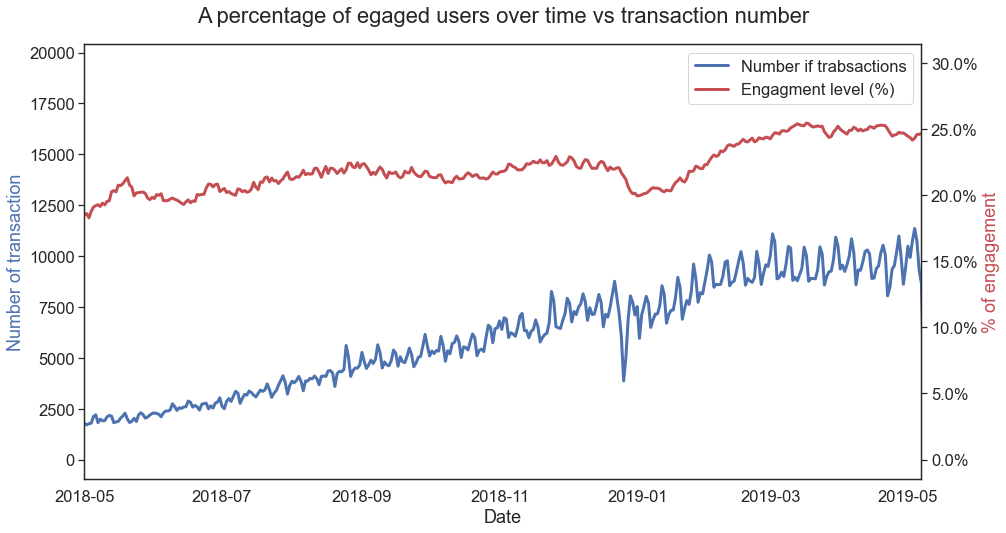

In [8]:
sns.set(style="white", font_scale=1.5, rc={"lines.linewidth": 3})

fig, ax1 = plt.subplots(figsize=(15,8))
ax1.set_xlim([datetime.date(2018, 5, 1), datetime.date(2019, 5,7)])
ax2 = ax1.twinx()

p1, = ax1.plot(list(trans_nbr.index),
               list(trans_nbr.values.reshape(-1)), 
               "b-", 
               label="Number if trabsactions")

p2, = ax2.plot(level.index,
               level.values.reshape(-1), 
               "r-", 
               label="Engagment level (%)")

ax1.set_xlabel("Date")
ax1.set_ylabel("Number of transaction")
ax2.set_ylabel("% of engagement")

ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1))

ax1.yaxis.label.set_color(p1.get_color())
ax2.yaxis.label.set_color(p2.get_color())

lines = [p1, p2]

ax1.legend(lines, [l.get_label() for l in lines])
ax1.set_title('A percentage of egaged users over time vs transaction number', pad=22, fontsize=22)


plt.show()


In [9]:
newest_trans_date = fake_last_date.created_date[0]
users = users.merge(trans_1_gr_d_cnt.query("created_date == '2019-05-15'").drop(columns=['created_date']), 
                    on=['user_id'],suffixes=('', ''))
users = users.assign(cooperation_time = lambda x: x['created_date'].apply(lambda x: (newest_trans_date-x).days))


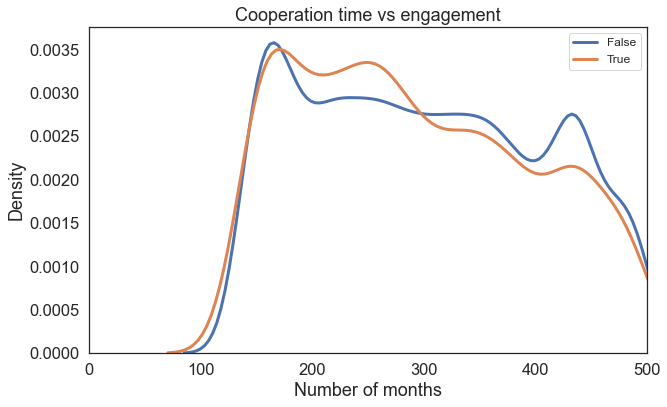

In [10]:

fig, ax1 = plt.subplots(figsize=(10,6))

for plan in users.eng_use3lastweeks.unique():
    g = sns.distplot(users.query("eng_use3lastweeks == {}".format(plan)).cooperation_time,  
                 kde=True, hist=False, label=plan, ax=ax1)

plt.legend(prop={'size': 12})
plt.title('Cooperation time vs engagement')
plt.xlabel('Number of months')
plt.ylabel('Density')
plt.xlim([0, 500])
plt.show()

In [11]:
first_date = datetime.date(2019, 5, 1)
second_date = (first_date-datetime.timedelta(days=1+3*pl)).strftime("%Y-%m-%d")
first_date=first_date.strftime("%Y-%m-%d")

In [12]:
print("In the next part, I'm going to analyzie data fro moment when they are stable: {}, and 3 week earlier - on {}.".\
      format(first_date,second_date))

In the next part, I'm going to analyzie data fro moment when they are stable: 2019-05-01, and 3 week earlier - on 2019-04-09.


In [13]:
engagement_data = trans_1_gr_d_cnt.\
    query("created_date in ('{}','{}')".format(first_date,second_date)).\
    reset_index(drop=True)

In [14]:
feather.write_dataframe(engagement_data, "./../data/engagement_data.feather")